<center><h1><b><u>Molecular Graphs</u></b></h1></center>

## __Importing Libraries, Classes, and Functions__

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx #focuses on network analysis and graph theory; can create/visualize graphs
import inspect #for viewing source code
import pprint


## __Viewing Source Code for Educational Purposes__

In [30]:
source_code = inspect.getsource(nx.Graph)

#with open('../source.py', 'w') as file:
    #file.write(source_code)

## __Molecular Graph Implementations__

### __Useful Method for Debugging__

In [31]:
def debug(obj, attribute_name = None):
    print(f"Type of object: {type(obj)}")

    print(f"Attributes of the object: {obj.__dict__}") #__attribute__ is special; __dict__ automatically creates
        
    if attribute_name is not None:
        has_attr = hasattr(obj, attribute_name)
        print(f"Has attribute '{attribute_name}': {has_attr}")
            
        if has_attr:
            print(f"Value of '{attribute_name}': {getattr(obj, attribute_name)}")
    print()

### __Custom One Hot Encoder__

In [32]:
class CustomOneHotEncoder:
    def __init__(self):
        self._categories = None #fit-related attributes not calculated in __init__
        self._cat_idx_map = None

    def fit(self, categories): #"learning" the unique categories
        self._categories = sorted(set(categories)) #encoding based lexographically usually; e.g. ['Carbon', 'Hydrogen']
        self._col_idx_map = {category: idx for idx, category in enumerate(self._categories)} #Indexing each category for column index {Carbon:0, Hydrogen, 1}
    
    def transform(self, category):
        one_hot = np.zeros(len(self._categories))
        one_hot[self._col_idx_map[category]] = 1
        return one_hot
    
    def fit_transform(self, categories): #shows all one hots for the categories
        self.fit(categories)
        return [self.transform(category) for category in categories]


In [33]:
categories = ['Carbon', 'Hydrogen']
_encoder = CustomOneHotEncoder()
#encoded_data = encoder.fit_transform(data)
_encoder.fit(categories)
encoded = _encoder.transform('Carbon') #needs to be list because transform expects 2D array
print(encoded)

[1. 0.]


### __Static Matrix Implementation__

In [34]:
class GraphMS: #Graph Matrix Static
    ATOM_TYPES = ['C', 'H', 'O'] #Carbon, Hydrogen, Oxygen

    def __init__(self, max_nodes = 6, max_edges = 12, **global_attributes):
        self._max_nodes = max_nodes
        self._max_edges = max_edges
        self._edge_pair_count = 0
        self._adj = np.zeros((max_nodes, max_nodes))
        self._node = None 
        self._edge = None
        self._node_indices = {}
        self._index_counter = 0
        self._graph = global_attributes
        self.encoder = CustomOneHotEncoder()

    def _create_node_feature_matrix(self):
        new_features = len(GraphMS.ATOM_TYPES) + 1  # +1 for non_bonding_valence
        self._node = np.zeros((self._max_nodes, new_features)) #Predefined 10 nodes
    
    def _add_node_features(self, row, non_bonding, atom_type):
        one_hot_atom = self.encoder.transform(atom_type) # [0 ...1..0]
            
        self._node[row, :len(one_hot_atom)] = one_hot_atom  # no looping, vectorized; put that vector in every element of row besides last column
        self._node[row, -1] = non_bonding  # last element of row

    def add_node(self, **node_attributes):
        if self._index_counter < self._max_nodes: #if space for node
            node_label = node_attributes['label']
            non_bonding = node_attributes['non_bonding_valence']
            atom_type = node_attributes['atom']

            self._node_indices[node_label] = self._index_counter #index in adj matrix
            row = self._index_counter #nth node corresponds to index row of feature matrix

            if self._node is None:
                self._create_node_feature_matrix()
                self.encoder.fit(GraphMS.ATOM_TYPES)  #updates categories and respective column indices
            
            self._add_node_features(row, non_bonding, atom_type)
            
            self._index_counter += 1
        else:
            print("Not enough space allocated.")
        
    def _check_missing_nodes(self, node1_label, node2_label):
        if node1_label not in self._node_indices and node2_label not in self._node_indices:
            raise ValueError(f'Missing {node1_label} and {node2_label}')
        elif node1_label not in self._node_indices:
            raise ValueError(f'Missing {node1_label}')
        elif node2_label not in self._node_indices:
            raise ValueError(f'Missing {node2_label}')
        
    
    def _add_edge_features(self, edge_features, reverse=False):
        if self._edge_pair_count >= self._max_edges/2:
            raise ValueError("Maximum number of edges reached")

        if not reverse:
            row_idx = self._edge_pair_count * 2
        else:
            row_idx = self._edge_pair_count * 2 + 1 #row index for reverse edge is the one after not reverse
        
        for col_idx, (attribute, attribute_val) in enumerate(edge_features.items()):
            self._edge[row_idx, col_idx] = attribute_val  # bond order

        if reverse:
            self._edge_pair_count += 1 #every edge is technically adding two

    def add_edge(self, node1_label, node2_label, **edge_features):
        self._check_missing_nodes(node1_label, node2_label)

        i, j = self._node_indices[node1_label], self._node_indices[node2_label]
        
        self._adj[i, j] = 1 #numpy indexing works like normal matrix; can use [i, j] instead of [i][j]
        self._adj[j, i] = 1 #Edge goes both ways for undirected

        if self._edge is None:
            self._edge = np.zeros((self._max_edges, len(edge_features))) #predefine 10 max edges

        self._add_edge_features(edge_features)
        self._add_edge_features(edge_features, reverse = True)
    
    def is_connection(self, i, j):
        return self._adj[i, j] == 1
    
    def to_nx(self):
        G = nx.Graph()
        
        for node_label in self._node_indices:
            G.add_node(node_label) #G is using nx methods; adjacency list by default

        added_edges = set() #so edges aren't repeatedly added to G
        count = 0
        for node1, i in self._node_indices.items(): #H1, 0; labels must be unique
            for node2, j in self._node_indices.items(): 
                if self.is_connection(i, j) and (i, j) not in added_edges and (j, i) not in added_edges: #only add if edge not seen
                    bond_order = self._edge[(count * 2), 0]
                    G.add_edge(node1, node2, bond_order=bond_order)  #don't need to add edge in both directions explicitly
                    added_edges.add((i, j))
                    added_edges.add((j, i))
                    count += 1
        
        return G
    
    def visualize(self):
        G = self.to_nx()
        pos = nx.spring_layout(G) #computes positions of the nodes on the graph so theres as few edge crossings possible and edge are around same length; pos = {label: [x,y], ...}

        edges = G.edges(data=True) #[(H1, O, {bond_order: 2}), ...]; can get attributes with methods that go through dicts in each tuple; G._adj contains this info
        bond_orders = [attribute_dict['bond_order'] for node1, node2, attribute_dict in edges] #list of the weights

        plt.figure(figsize=(5, 5))
        nx.draw(G, pos, with_labels=True, width = bond_orders, node_color='#ff91af', edge_color='pink', font_size = 9, node_size = 2000) 
        
        edge_labels = nx.get_edge_attributes(G, 'bond_order') #iterates through all the attributedict[bondorder] in _adj; creates {('H1', 'O'): 1, ('H2', 'O'): 1}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    def _print_matrix(self, name, matrix):
        print(name)
        for row in matrix:
            print(" ".join(str(element) for element in row)) #join method works with any iterable, including generator
        print()
    
    def adjacency_to_edge_index(self):
        edge_index_row = [] #alternatively use np.nonzero and np.vstack (vertical stack)
        edge_index_col = []

        #Find all non zero edges
        for i in range(len(self._adj)):
            for j in range(len(self._adj[i])):
                if self._adj[i][j] == 1:
                    edge_index_row.append(i)
                    edge_index_col.append(j)
   
        return np.array([edge_index_row, 
                         edge_index_col]) #this vertically stacks them

    def __str__(self):
        print(f'Graph Attributes: {self._graph}')
        self._print_matrix("Adjacency Matrix:", self._adj)

        edge_index = self.adjacency_to_edge_index()
        self._print_matrix("Edge Index:", edge_index)

        self._print_matrix("Node Feature Matrix:", self._node)
        self._print_matrix("Edge Feature Matrix:", self._edge)

        connections = [] #printing connection of every node
        for node1, i in self._node_indices.items():
            for node2, j in self._node_indices.items():
                ij_connection = self._adj[i, j]
                if self.is_connection(i, j):
                    connections.append(f"{node1} -- {node2}, Bond Order: {ij_connection}")
        return "\n".join(connections)

In [35]:
graph = GraphMS(max_nodes = 4, max_edges = 8, name="H2O")

graph.add_node(label = 'H1', atom = 'H', non_bonding_valence = 0)
graph.add_node(label = 'O', atom = 'O', non_bonding_valence = 4)
graph.add_node(label = 'H2', atom = 'H', non_bonding_valence = 0)

try:
    graph.add_edge('H1', 'O', bond_order=1) #or {'bond_order': 1}
    graph.add_edge('H2', 'O', bond_order=1)
except ValueError as e:
    print(e) #quit()/sys.exit(1) not needed

print(graph)

Graph Attributes: {'name': 'H2O'}
Adjacency Matrix:
0.0 1.0 0.0 0.0
1.0 0.0 1.0 0.0
0.0 1.0 0.0 0.0
0.0 0.0 0.0 0.0

Edge Index:
0 1 1 2
1 0 2 1

Node Feature Matrix:
0.0 1.0 0.0 0.0
0.0 0.0 1.0 4.0
0.0 1.0 0.0 0.0
0.0 0.0 0.0 0.0

Edge Feature Matrix:
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0

H1 -- O, Bond Order: 1.0
O -- H1, Bond Order: 1.0
O -- H2, Bond Order: 1.0
H2 -- O, Bond Order: 1.0


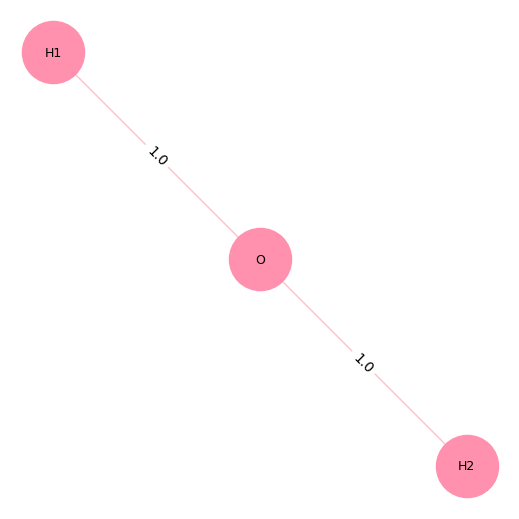

In [68]:
graph.visualize()

### __Dynamic Matrix Implementation__

In [37]:
class GraphMD: # Graph Matrix Dynamic
    class Node:
        ATOM_TYPES = ['C', 'H', 'O'] # Carbon, Hydrogen, Oxygen
        def __init__(self, node_attributes, encoder):
            self._label = node_attributes['label']
            self._atom_type = node_attributes['atom']
            self._non_bonding_valence = node_attributes['non_bonding_valence']
            self._encoder = encoder
            self._features = None #[one_hot_atom_type   non_bonding]; Feature matrices can be created now once the graph is complete
            
        def create_feature_vector(self): 
            one_hot_atom = self._encoder.transform(self._atom_type)
            self._features = np.append(one_hot_atom, self._non_bonding_valence) #combines the two into single array

    class Edge:
        def __init__(self, node1, node2, edge_features):
            self._node1 = node1
            self._node2 = node2
            self._features_dict = edge_features
            self._features = None

        def create_feature_vector(self):
            self._features = np.array(list(self._features_dict.values())) #view object from values can't directly be converted to np; [bond_order]

    def __init__(self, max_nodes=6, **global_attributes): #** in function definition -> it packs keyword arguments into a dictionary
        self._max_nodes = max_nodes
        self._adj = np.zeros((max_nodes, max_nodes))
        self._nodes = {} #{node1label: Node1obj}
        self._edges = [] #list of edge objects
        self.encoder = CustomOneHotEncoder()
        self._graph = global_attributes
    
    def add_node(self, **node_attributes):
        if not self._nodes: #if no nodes in graph
            self.encoder.fit(GraphMD.Node.ATOM_TYPES) #get categories and indices during graph creation

        if len(self._nodes) < self._max_nodes:
            node = GraphMD.Node(node_attributes, self.encoder)
            node.create_feature_vector()
            self._nodes[node._label] = node #add node to dict
        else:
            raise ValueError("Not enough node space allocated.")
        

    def _check_missing_nodes(self, node1_label, node2_label):
        if node1_label not in self._nodes and node2_label not in self._nodes:
            raise ValueError(f'Missing {node1_label} and {node2_label}')
        elif node1_label not in self._nodes:
            raise ValueError(f'Missing {node1_label}')
        elif node2_label not in self._nodes:
            raise ValueError(f'Missing {node2_label}')
    
    def add_edge(self, node1_label, node2_label, **edge_features_dict):
        self._check_missing_nodes(node1_label, node2_label)

        node1 = self._nodes[node1_label]
        node2 = self._nodes[node2_label]

        node_labels = list(self._nodes.values())
        i, j = node_labels.index(node1), node_labels.index(node2) #indices for _adj

        #Add edges to adjacency list
        self._adj[i, j] = 1
        self._adj[j, i] = 1
        
        #Create features/edge objects
        edge = GraphMD.Edge(node1, node2, edge_features_dict) 
        edge.create_feature_vector()
        reverse_edge = GraphMD.Edge(node2, node1, edge_features_dict)
        reverse_edge.create_feature_vector()

        self._edges.append(edge)
        self._edges.append(reverse_edge)
    
    def is_connection(self, i, j):
        return self._adj[i, j] == 1
    
    def to_nx(self):
        G = nx.Graph()
        for node_label in self._nodes:
            G.add_node(node_label)
        
        for edge in self._edges:
            G.add_edge(edge._node1._label, edge._node2._label, **edge._features_dict) #turns to bond_order=1; #** unpacks in function call
        
        return G
    
    def visualize(self):
        G = self.to_nx()
        pos = nx.spring_layout(G)
        edges = G.edges(data=True)
        bond_orders = [attribute['bond_order'] for node1, node2, attribute in edges]
        
        plt.figure(figsize=(5, 5))
        nx.draw(G, pos, with_labels=True, width=bond_orders, node_color='#ff91af', edge_color='pink', font_size=9, node_size=2000)
        edge_labels = nx.get_edge_attributes(G, 'bond_order')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    def _print_matrix(self, name, matrix):
        print(name)
        for row in matrix:
            print(" ".join(str(element) for element in row))
        print()
    
    def adjacency_to_edge_index(self):
        edge_index_row = [] 
        edge_index_col = []

        for i in range(len(self._adj)):
            for j in range(len(self._adj[i])):
                if self._adj[i][j] == 1:
                    edge_index_row.append(i)
                    edge_index_col.append(j)
   
        return np.array([edge_index_row, edge_index_col])
    
    def __str__(self):
        print(f'Graph Attributes: {self._graph}')
        self._print_matrix("Adjacency Matrix:", self._adj)

        edge_index = self.adjacency_to_edge_index()
        self._print_matrix("Edge Index:", edge_index)

        node_features = np.array([node._features for node in self._nodes.values()]) #creating the node feature matrix by combining all node feature vectors
        self._print_matrix("Node Feature Matrix:", node_features)
        
        #Create and print edge feature matrix
        num_edge_features = len(self._edges[0]._features)
        edge_features = np.zeros((len(self._edges), num_edge_features))
        for idx, edge in enumerate(self._edges):
            edge_features[idx] = edge._features #replace feature rows with actual features from dict
        self._print_matrix("Edge Feature Matrix:", edge_features)
        
        connections = []
        for edge in self._edges:
            connections.append(f"{edge._node1._label} -- {edge._node2._label}, Bond Order: {edge._features_dict['bond_order']}")
        return "\n".join(connections)

In [38]:
water = GraphMD(max_nodes = 3, name="H2O")

water.add_node(label = 'H1', atom = 'H', non_bonding_valence = 0)
water.add_node(label = 'O', atom = 'O', non_bonding_valence = 4)
water.add_node(label = 'H2', atom = 'H', non_bonding_valence = 0)

try:
    water.add_edge('H1', 'O', bond_order=1) 
    water.add_edge('H2', 'O', bond_order=1)
except ValueError as e:
    print(e)

print(water)

Graph Attributes: {'name': 'H2O'}
Adjacency Matrix:
0.0 1.0 0.0
1.0 0.0 1.0
0.0 1.0 0.0

Node Feature Matrix:
0.0 1.0 0.0 0.0
0.0 0.0 1.0 4.0
0.0 1.0 0.0 0.0

Edge Feature Matrix:
1.0
1.0
1.0
1.0

H1 -- O, Bond Order: 1
O -- H1, Bond Order: 1
H2 -- O, Bond Order: 1
O -- H2, Bond Order: 1


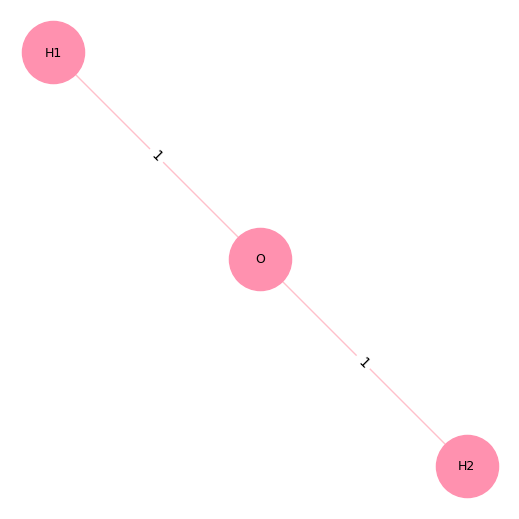

In [71]:
water.visualize()

### __Dictionary Implementation__

In [40]:
class GraphD:
    class Node:
        ATOM_TYPE = ['C', 'H', 'O']

        _unique_id = 0
        
        @classmethod
        def increment_id(cls):
            cls._unique_id += 1

        def __init__(self, label, node_features, encoder):
            self._label = label
            self.atom_type = node_features['atom']
            self.non_bonding = node_features['non_bonding_valence']
            self.encoder = encoder
            self.hot_atom = None
            self.feature_dict =  None
            
            self._unique_id = GraphD.Node._unique_id
            GraphD.Node.increment_id()
            
        def _encode_features(self):
            self.hot_atom = self.encoder.transform(self.atom_type)
            self.feature_dict = {'label' : self._label, 'atom' : self.hot_atom, 'non_bonding_valence' : self.non_bonding}
        
    class Edge:
        def __init__(self, node1, node2, edge_features):
            self._node1 = node1
            self._node2 = node2
            self._features = edge_features
    
    def __init__(self, **global_attributes):
        self._adj = {} #contains edge features
        self._node = {}
        self._edges = []
        self._graph = global_attributes
        self._label_to_id = {}  #for creating edges
        self.encoder = CustomOneHotEncoder()

    def add_node(self, label, **node_features):
        if not self._node:
            self.encoder.fit(GraphD.Node.ATOM_TYPE)

        if label not in self._node.keys():
            node = GraphD.Node(label, node_features, self.encoder)
            node._encode_features()
            
            self._node[node._unique_id] = node.feature_dict
            self._adj[node._unique_id] = {} #values of this will be {neighbor: edge attributes}
            self._label_to_id[node._label] = node._unique_id
    
    def _check_missing_nodes(self, node1_label, node2_label):
        if node1_label not in self._label_to_id and node2_label not in self._label_to_id:
            raise ValueError(f'Missing {node1_label} and {node2_label}')
        elif node1_label not in self._label_to_id:
            raise ValueError(f'Missing {node1_label}')
        elif node2_label not in self._label_to_id:
            raise ValueError(f'Missing {node2_label}')
   
    def add_edge(self, node1_label, node2_label, **bond_order):
        self._check_missing_nodes(node1_label, node2_label)

        node1_id = self._label_to_id[node1_label]
        node2_id = self._label_to_id[node2_label]

        node1 = self._node[node1_id]
        node2 = self._node[node2_id]

        edge = GraphD.Edge(node1, node2, bond_order)
        reverse_edge = GraphD.Edge(node2, node1, bond_order)
        
        self._adj[node1_id][node2_id] = edge._features #only storing features in _adj and _node instead of whole object
        self._adj[node2_id][node1_id] = reverse_edge._features

        self._edges.append(edge) #for easier printing at end
        self._edges.append(reverse_edge)

    def to_nx(self):
        G = nx.Graph()
        for node_features in self._node.values():
            G.add_node(node_features['label'])
        
        for edge in self._edges:
            G.add_edge(edge._node1['label'], edge._node2['label'], **edge._features) #turns to bond_order=1; #** unpacks in function call
        
        return G
    
    def visualize(self):
        G = self.to_nx()
        pos = nx.spring_layout(G)
        edges = G.edges(data=True)
        bond_orders = [attribute['bond_order'] for node1, node2, attribute in edges]
        
        plt.figure(figsize=(6, 6))
        nx.draw(G, pos, with_labels=True, width=bond_orders, node_color='#ff91af', edge_color='pink', font_size=9, node_size=2000)
        edge_labels = nx.get_edge_attributes(G, 'bond_order')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
        
    def __str__(self):
        pp = pprint.PrettyPrinter(indent=4)

        print(f"Graph Attributes:\n{pp.pformat(self._graph)}\n")
        print(f"Nodes:\n{pp.pformat(self._node)}\n")
        print(f"Edges:\n{pp.pformat(self._adj)}\n")
        
        print()
        connections = []
        for edge in self._edges:
            connections.append(f"{edge._node1['label']} -- {edge._node2['label']}, Bond Order: {edge._features['bond_order']}")
        return "\n".join(connections)

In [41]:
molecule = GraphD(name="H2O")

molecule.add_node(label = 'H1', atom = 'H', non_bonding_valence = 0)
molecule.add_node(label = 'O', atom = 'O', non_bonding_valence = 4)
molecule.add_node(label = 'H2', atom = 'H', non_bonding_valence = 0)

molecule.add_edge('H1', 'O', bond_order=1) 
molecule.add_edge('H2', 'O', bond_order=1)

print(molecule)

Graph Attributes:
{'name': 'H2O'}

Nodes:
{   0: {'atom': array([0., 1., 0.]), 'label': 'H1', 'non_bonding_valence': 0},
    1: {'atom': array([0., 0., 1.]), 'label': 'O', 'non_bonding_valence': 4},
    2: {'atom': array([0., 1., 0.]), 'label': 'H2', 'non_bonding_valence': 0}}

Edges:
{   0: {1: {'bond_order': 1}},
    1: {0: {'bond_order': 1}, 2: {'bond_order': 1}},
    2: {1: {'bond_order': 1}}}


H1 -- O, Bond Order: 1
O -- H1, Bond Order: 1
H2 -- O, Bond Order: 1
O -- H2, Bond Order: 1


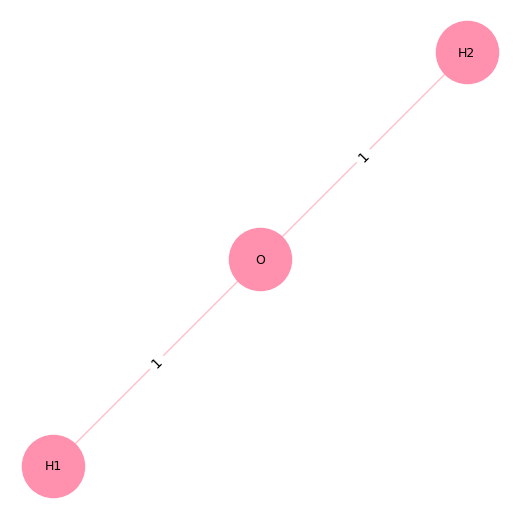

In [74]:
molecule.visualize()